# Optogenetic Spike Count Analysis for All Subjects

This notebook processes all subjects with optogenetic stimulation data from DANDI dataset 000253 and creates unit spike count plots similar to the example in `test_opto_stim.ipynb`.

In [ ]:
# Import required libraries
import os
import re
import pynwb
import h5py
import remfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from dandi.dandiapi import DandiAPIClient
from pathlib import Path
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set up plotting parameters
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [7]:
# Analysis parameters (from test_opto_stim.ipynb)
STIM_DURATION = 0.010  # 10 ms
CENSOR_PERIOD = 0.002  # 2 ms
TIME_RESOLUTION = 0.001  # 1 ms
WINDOW_START_TIME = -0.01  # 10 ms before stimulus
WINDOW_END_TIME = 0.025   # 25 ms after stimulus

# Output directory
OUTPUT_DIR = Path("opto_spike_plots")
OUTPUT_DIR.mkdir(exist_ok=True)

print(f"Analysis parameters:")
print(f"  Stimulus duration: {STIM_DURATION*1000} ms")
print(f"  Censor period: {CENSOR_PERIOD*1000} ms")
print(f"  Time resolution: {TIME_RESOLUTION*1000} ms")
print(f"  Analysis window: {WINDOW_START_TIME*1000} to {WINDOW_END_TIME*1000} ms")
print(f"  Output directory: {OUTPUT_DIR}")

Analysis parameters:
  Stimulus duration: 10.0 ms
  Censor period: 2.0 ms
  Time resolution: 1.0 ms
  Analysis window: -10.0 to 25.0 ms
  Output directory: opto_spike_plots


In [ ]:
# Functions from test_opto_stim.ipynb

def sanitize_filename(text):
    """Sanitize a string to be safe for use in filenames"""
    # Replace problematic characters with underscores
    return re.sub(r'[/<>:"|?*]', '_', text)

def get_spike_matrix(stim_times, units_spike_times, bin_edges):
    """Create 3D spike matrix: units x trials x time_bins"""
    time_resolution = np.mean(np.diff(bin_edges))
    spike_matrix = np.zeros((len(units_spike_times), len(stim_times), len(bin_edges)-1))

    for unit_idx in tqdm(range(len(units_spike_times)), desc="Processing units"):
        spike_times = units_spike_times[unit_idx]

        for stim_idx, stim_time in enumerate(stim_times):
            # Get spike times within window
            first_bin_time = stim_time + bin_edges[0]
            last_bin_time = stim_time + bin_edges[-1]
            first_spike_in_range, last_spike_in_range = np.searchsorted(
                spike_times, [first_bin_time, last_bin_time])
            spike_times_in_range = spike_times[first_spike_in_range:last_spike_in_range]

            # Convert to bin indices
            bin_indices = ((spike_times_in_range - first_bin_time) / time_resolution).astype(int)
            
            # Count spikes in bins
            for bin_idx in bin_indices:
                if 0 <= bin_idx < spike_matrix.shape[2]:
                    spike_matrix[unit_idx, stim_idx, bin_idx] += 1

    return spike_matrix

def get_spike_counts(stim_times, spike_times):
    """Calculate spike counts and analysis parameters"""
    # Create time bins
    n_bins = int((WINDOW_END_TIME - WINDOW_START_TIME) / TIME_RESOLUTION)
    bin_edges = np.linspace(WINDOW_START_TIME, WINDOW_END_TIME, n_bins, endpoint=True)

    # Calculate interval indices
    stim_start_time = CENSOR_PERIOD
    stim_end_time = STIM_DURATION - CENSOR_PERIOD
    stim_start_idx = int((stim_start_time - bin_edges[0]) / TIME_RESOLUTION)
    stim_end_idx = int((stim_end_time - bin_edges[0]) / TIME_RESOLUTION)
    bl_start_idx = 0
    bl_end_idx = int((0 - CENSOR_PERIOD - bin_edges[0]) / TIME_RESOLUTION)

    # Get spike matrix
    spike_matrix = get_spike_matrix(stim_times, spike_times, bin_edges)
    
    # Aggregate across trials
    spike_counts = np.sum(spike_matrix, axis=1)

    return {
        'spike_counts': spike_counts,
        'spike_matrix': spike_matrix,
        'bin_edges': bin_edges,
        'bl_start_idx': bl_start_idx,
        'bl_end_idx': bl_end_idx,
        'stim_start_idx': stim_start_idx,
        'stim_end_idx': stim_end_idx
    }

def plot_spike_counts(spike_counts, bin_edges, stim_start_idx, stim_end_idx, 
                     subject_id, genotype, save_plot=True):
    """Create spike count heatmap plot"""
    # Sort units by mean response during stimulus period
    unit_response_means = np.mean(spike_counts[:, stim_start_idx:stim_end_idx], axis=1)
    sorted_response_idxs = np.argsort(unit_response_means)
    sorted_spike_counts = spike_counts[sorted_response_idxs, :]

    # Create figure
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot heatmap
    vmax = np.percentile(sorted_spike_counts, 95)  # Use 95th percentile as max
    img = ax.imshow(sorted_spike_counts, 
                   extent=[np.min(bin_edges), np.max(bin_edges), 0, len(sorted_spike_counts)], 
                   aspect="auto",
                   vmin=0,
                   vmax=max(vmax, 1))  # Ensure vmax is at least 1

    # Add stimulus boundaries
    stim_bounds = [CENSOR_PERIOD, STIM_DURATION - CENSOR_PERIOD]
    for bound in stim_bounds:
        ax.axvline(x=bound, color='white', linestyle=':', linewidth=2.0)

    # Add stimulus onset line
    ax.axvline(x=0, color='red', linestyle='-', linewidth=2.0, alpha=0.7)

    # Labels and title
    ax.set_xlabel("Time relative to stimulus onset (s)", fontsize=12)
    ax.set_ylabel("Unit # (sorted by response strength)", fontsize=12)
    ax.set_title(f"{subject_id} - {genotype}\nUnit spike counts over time", fontsize=14)

    # Colorbar
    cbar = fig.colorbar(img, shrink=0.6)
    cbar.set_label(f"# Spikes (per {TIME_RESOLUTION} seconds)", fontsize=11)

    # Add text with key info
    ax.text(0.02, 0.98, f"n_units = {len(sorted_spike_counts)}", 
            transform=ax.transAxes, verticalalignment='top', 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()

    if save_plot:
        # Sanitize genotype for filename
        safe_genotype = sanitize_filename(genotype)
        filename = f"{subject_id}_{safe_genotype}_spike_counts.png"
        filepath = OUTPUT_DIR / filename
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
        print(f"  Saved plot: {filepath}")

    return fig

print("Functions defined successfully!")

Functions defined successfully!


In [ ]:
# Test the sanitize_filename function with the problematic genotype
test_genotype = "Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt"
safe_genotype = sanitize_filename(test_genotype)
print(f"Original genotype: {test_genotype}")
print(f"Safe genotype: {safe_genotype}")

# Test the full filename creation
test_subject_id = "sub-621890"
test_filename = f"{test_subject_id}_{safe_genotype}_spike_counts.png"
test_filepath = OUTPUT_DIR / test_filename
print(f"Full file path: {test_filepath}")
print(f"Path exists: {test_filepath.parent.exists()}")
print(f"Path is valid: {test_filepath.parent.is_dir()}")

In [ ]:
# Test actually creating a file with the sanitized filename
import matplotlib.pyplot as plt

# Create a simple test plot
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot([1, 2, 3], [1, 4, 2])
ax.set_title("Test plot")

# Test saving with the problematic genotype
test_genotype = "Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt"
safe_genotype = sanitize_filename(test_genotype)
test_filename = f"test_{safe_genotype}.png"
test_filepath = OUTPUT_DIR / test_filename

try:
    plt.savefig(test_filepath, dpi=150, bbox_inches='tight')
    print(f"✅ Successfully saved test file: {test_filepath}")
    print(f"File exists: {test_filepath.exists()}")
except Exception as e:
    print(f"❌ Error saving test file: {e}")
    
plt.close(fig)

In [8]:
# Connect to DANDI and get dataset info
dandiset_id = "000253"
print(f"Connecting to DANDI dataset {dandiset_id}...")

client = DandiAPIClient()
dandiset = client.get_dandiset(dandiset_id, "draft")

# Get all assets
assets = list(dandiset.get_assets())
print(f"Found {len(assets)} total assets")

# Filter for main session files (not probe-specific)
main_assets = [asset for asset in assets if "probe" not in asset.path]
print(f"Found {len(main_assets)} main session files")

# Show first few assets
print("\nFirst few assets:")
for i, asset in enumerate(main_assets[:5]):
    print(f"  {i+1}. {asset.path}")

Connecting to DANDI dataset 000253...
Found 98 total assets
Found 14 main session files

First few assets:
  1. sub-621890/sub-621890_ses-1186358749_ogen.nwb
  2. sub-632487/sub-632487_ses-1204677304_ogen.nwb
  3. sub-637542/sub-637542_ses-1211241460_ogen.nwb
  4. sub-632485/sub-632485_ses-1203581890_ogen.nwb
  5. sub-637909/sub-637909_ses-1212569512_ogen.nwb



Processing sub-621890...
  Genotype: Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt
  Units: 2446
  Stimuli: 450
  Stimulus conditions: ['Each pulse is 10 ms wide' 'Each pulse is 6 ms wide'
 'half-period of a cosine wave']
  Using 150 stimuli
  Genotype: Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt
  Units: 2446
  Stimuli: 450
  Stimulus conditions: ['Each pulse is 10 ms wide' 'Each pulse is 6 ms wide'
 'half-period of a cosine wave']
  Using 150 stimuli


Processing units: 100%|██████████| 2446/2446 [01:25<00:00, 28.76it/s]



  Error processing sub-621890: [Errno 2] No such file or directory: 'opto_spike_plots/sub-621890_Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt_spike_counts.png'

Processing sub-632487...
  Genotype: Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt
  Units: 2745
  Stimuli: 450
  Stimulus conditions: ['Each pulse is 6 ms wide' 'Each pulse is 10 ms wide'
 'half-period of a cosine wave']
  Using 150 stimuli
  Genotype: Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt
  Units: 2745
  Stimuli: 450
  Stimulus conditions: ['Each pulse is 6 ms wide' 'Each pulse is 10 ms wide'
 'half-period of a cosine wave']
  Using 150 stimuli


Processing units: 100%|██████████| 2745/2745 [01:18<00:00, 34.82it/s]



  Error processing sub-632487: [Errno 2] No such file or directory: 'opto_spike_plots/sub-632487_Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt_spike_counts.png'

Processing sub-637542...
  Genotype: Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt
  Units: 2055
  Stimuli: 450
  Stimulus conditions: ['Each pulse is 6 ms wide' 'half-period of a cosine wave'
 'Each pulse is 10 ms wide']
  Using 150 stimuli
  Genotype: Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt
  Units: 2055
  Stimuli: 450
  Stimulus conditions: ['Each pulse is 6 ms wide' 'half-period of a cosine wave'
 'Each pulse is 10 ms wide']
  Using 150 stimuli


Processing units: 100%|██████████| 2055/2055 [01:30<00:00, 22.78it/s]



  Error processing sub-637542: [Errno 2] No such file or directory: 'opto_spike_plots/sub-637542_Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt_spike_counts.png'

Processing sub-632485...
  Genotype: Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt
  Units: 2272
  Stimuli: 450
  Stimulus conditions: ['Each pulse is 6 ms wide' 'half-period of a cosine wave'
 'Each pulse is 10 ms wide']
  Using 150 stimuli
  Genotype: Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt
  Units: 2272
  Stimuli: 450
  Stimulus conditions: ['Each pulse is 6 ms wide' 'half-period of a cosine wave'
 'Each pulse is 10 ms wide']
  Using 150 stimuli


Processing units: 100%|██████████| 2272/2272 [01:23<00:00, 27.20it/s]



  Error processing sub-632485: [Errno 2] No such file or directory: 'opto_spike_plots/sub-632485_Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt_spike_counts.png'

Processing sub-637909...
  Genotype: Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt
  Units: 2414
  Stimuli: 450
  Stimulus conditions: ['half-period of a cosine wave' 'Each pulse is 10 ms wide'
 'Each pulse is 6 ms wide']
  Using 150 stimuli
  Genotype: Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt
  Units: 2414
  Stimuli: 450
  Stimulus conditions: ['half-period of a cosine wave' 'Each pulse is 10 ms wide'
 'Each pulse is 6 ms wide']
  Using 150 stimuli


Processing units:  81%|████████  | 1948/2414 [01:06<00:15, 29.51it/s]



KeyboardInterrupt: 

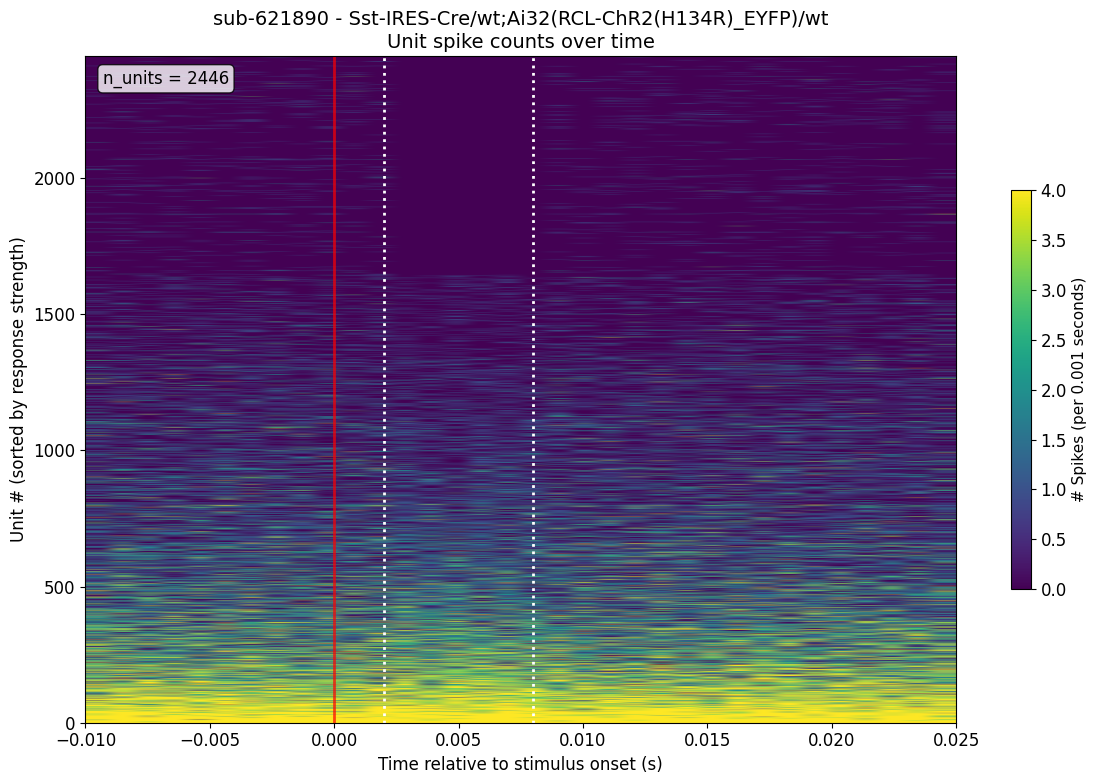

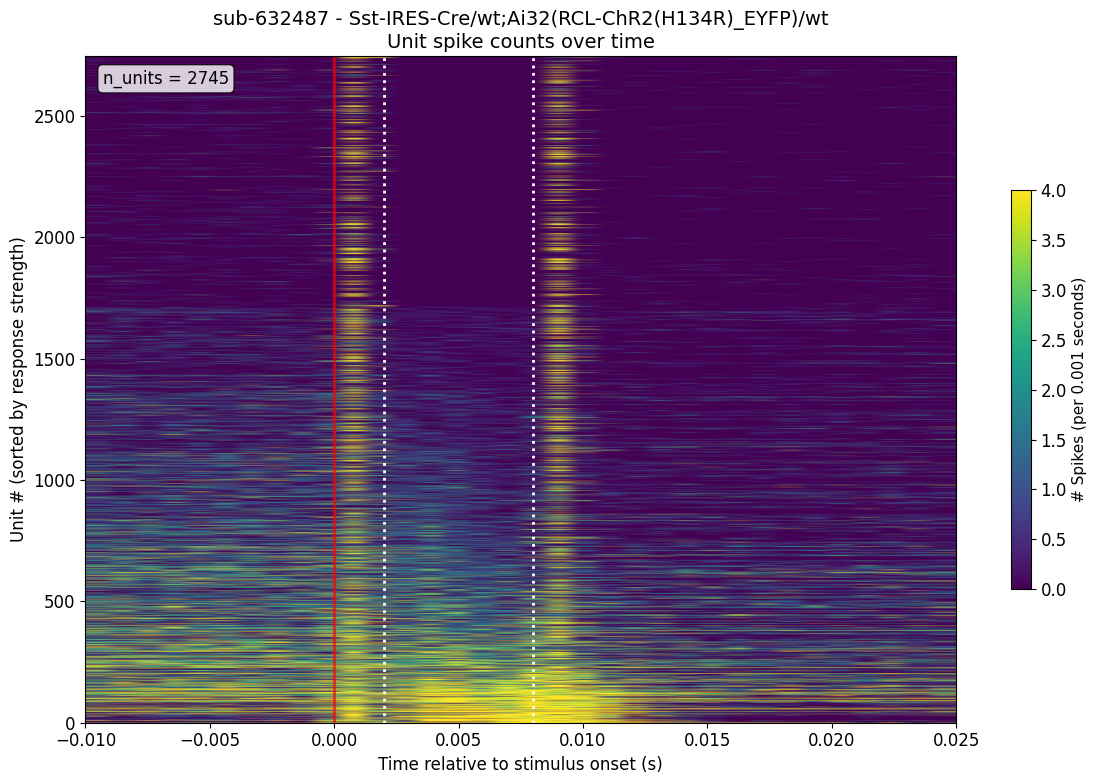

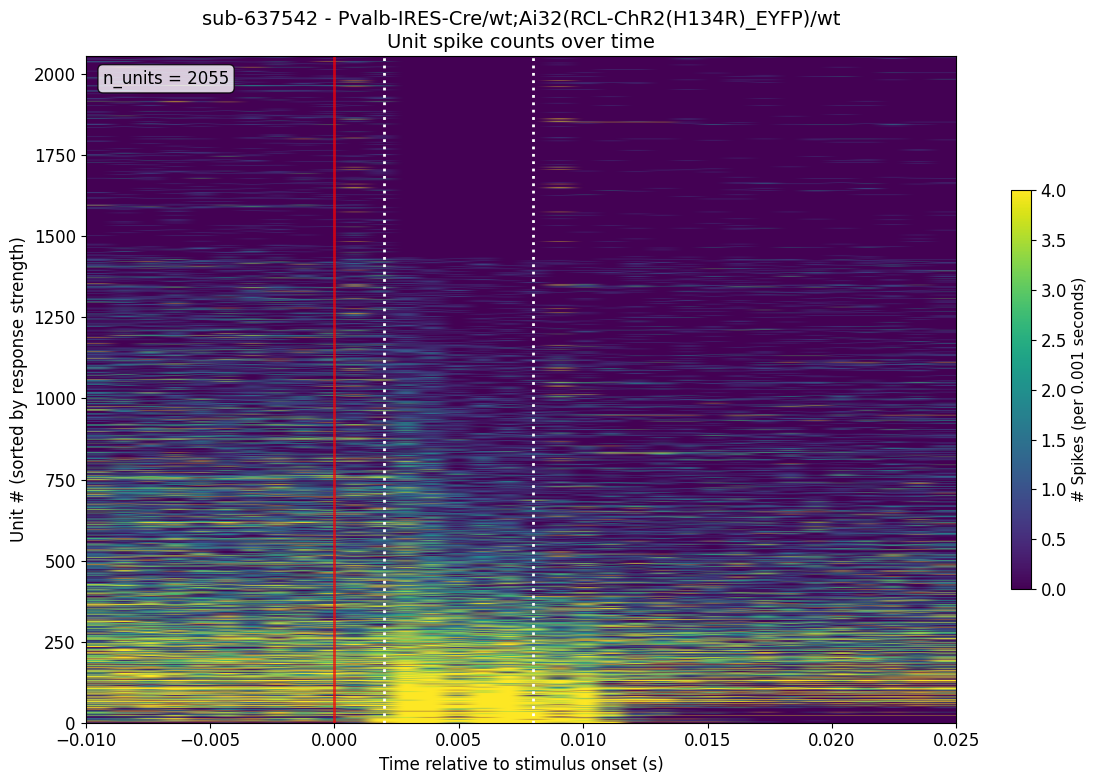

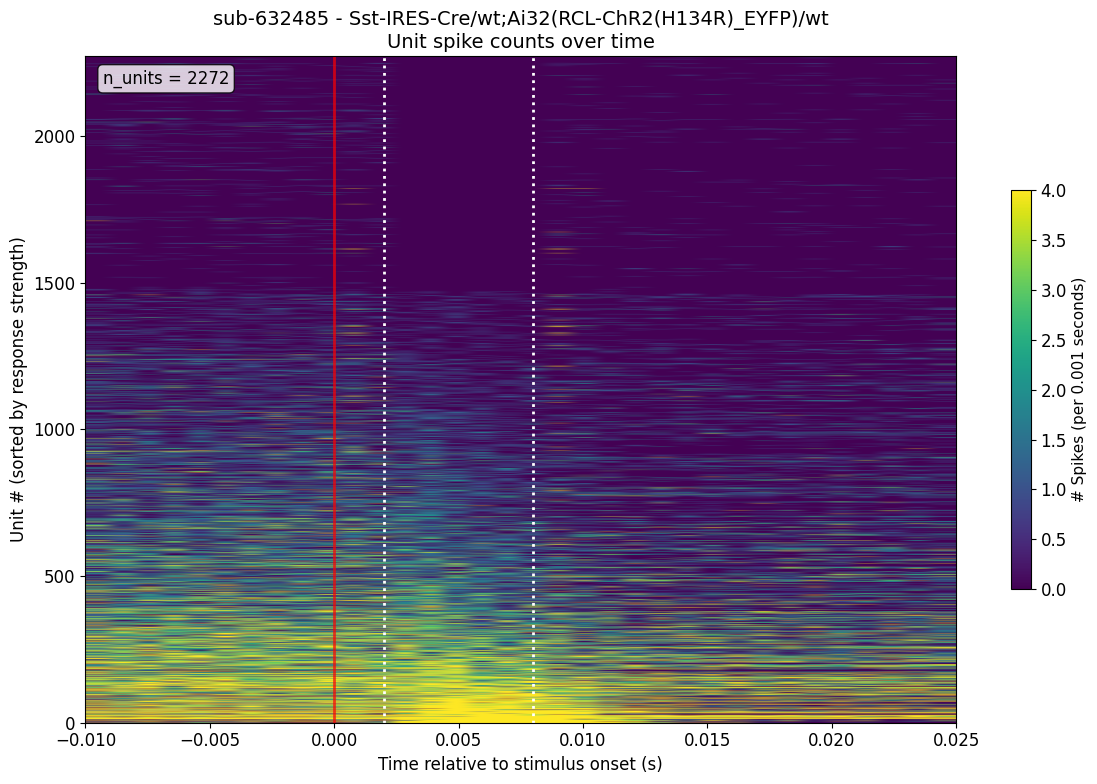

In [9]:
# Process each subject
results = {}
processed_subjects = set()
successful_subjects = []

def process_subject(subject_id, asset):
    """Process a single subject's data"""
    print(f"\nProcessing {subject_id}...")
    
    try:
        # Load NWB file
        url = asset.download_url
        remote_file = remfile.File(url)
        h5_file = h5py.File(remote_file)
        io = pynwb.NWBHDF5IO(file=h5_file, load_namespaces=True)
        nwb = io.read()

        # Check for required data
        if not hasattr(nwb, 'units') or nwb.units is None or len(nwb.units) == 0:
            print(f"  No units data found for {subject_id}")
            return None

        # Check for optogenetic stimulation data
        if not (hasattr(nwb, 'processing') and 'optotagging' in nwb.processing):
            print(f"  No optotagging data found for {subject_id}")
            return None

        optotagging_module = nwb.processing['optotagging']
        if 'optogenetic_stimulation' not in optotagging_module.data_interfaces:
            print(f"  No optogenetic_stimulation table found for {subject_id}")
            return None

        # Get stimulus data
        stim_table = optotagging_module.data_interfaces['optogenetic_stimulation']
        stim_df = stim_table.to_dataframe()
        
        # Get subject info
        genotype = "unknown"
        if hasattr(nwb, 'subject') and nwb.subject:
            genotype = nwb.subject.genotype or "unknown"

        print(f"  Genotype: {genotype}")
        print(f"  Units: {len(nwb.units)}")
        print(f"  Stimuli: {len(stim_df)}")

        # Get stimulus times
        if 'condition' in stim_df.columns:
            conditions = stim_df['condition'].unique()
            print(f"  Stimulus conditions: {conditions}")
            
            # Try to find appropriate condition
            if 'a single square pulse' in conditions:
                condition = 'a single square pulse'
            elif 'Each pulse is 10 ms wide' in conditions:
                condition = 'Each pulse is 10 ms wide'
            else:
                condition = conditions[0]  # Use first available condition
                
            stim_times = stim_df['start_time'][stim_df['condition'] == condition].to_numpy()
        else:
            # If no condition column, use all stimuli
            stim_times = stim_df['start_time'].to_numpy()

        print(f"  Using {len(stim_times)} stimuli")
        
        if len(stim_times) == 0:
            print(f"  No valid stimuli found for {subject_id}")
            return None

        # Get spike times
        spike_times = nwb.units['spike_times']
        
        # Analyze spike counts
        analysis_results = get_spike_counts(stim_times, spike_times)
        
        # Create plot
        fig = plot_spike_counts(
            analysis_results['spike_counts'], 
            analysis_results['bin_edges'],
            analysis_results['stim_start_idx'],
            analysis_results['stim_end_idx'],
            subject_id, 
            genotype
        )
        
        plt.show()
        plt.close(fig)  # Close to save memory

        # Store results
        subject_results = {
            'subject_id': subject_id,
            'genotype': genotype,
            'n_units': len(nwb.units),
            'n_stimuli': len(stim_times),
            'spike_counts': analysis_results['spike_counts'],
            'bin_edges': analysis_results['bin_edges'],
            'mean_response_rate': np.mean(analysis_results['spike_counts'][:, analysis_results['stim_start_idx']:analysis_results['stim_end_idx']]),
            'baseline_rate': np.mean(analysis_results['spike_counts'][:, analysis_results['bl_start_idx']:analysis_results['bl_end_idx']])
        }

        # Clean up
        io.close()
        h5_file.close()

        return subject_results

    except Exception as e:
        print(f"  Error processing {subject_id}: {e}")
        return None

# Process all subjects
for asset in main_assets:
    # Extract subject ID
    path_parts = asset.path.split('/')
    if len(path_parts) > 0 and path_parts[0].startswith('sub-'):
        subject_id = path_parts[0]
        
        # Skip if already processed
        if subject_id in processed_subjects:
            continue
            
        # Process subject
        result = process_subject(subject_id, asset)
        if result is not None:
            results[subject_id] = result
            successful_subjects.append(subject_id)
            
        processed_subjects.add(subject_id)
        
        # Limit to first few subjects for testing (remove this line to process all)
        if len(successful_subjects) >= 3:
            break

print(f"\nProcessing complete!")
print(f"Successfully processed {len(successful_subjects)} subjects:")
for subject_id in successful_subjects:
    result = results[subject_id]
    print(f"  {subject_id}: {result['genotype']} - {result['n_units']} units")

In [ ]:
# Create summary analysis
if results:
    # Prepare data for summary
    subject_ids = []
    genotypes = []
    n_units = []
    mean_responses = []
    baseline_rates = []
    
    for subject_id, result in results.items():
        subject_ids.append(subject_id)
        genotypes.append(result['genotype'])
        n_units.append(result['n_units'])
        mean_responses.append(result['mean_response_rate'])
        baseline_rates.append(result['baseline_rate'])
    
    # Create summary DataFrame
    summary_df = pd.DataFrame({
        'subject_id': subject_ids,
        'genotype': genotypes,
        'n_units': n_units,
        'mean_response_rate': mean_responses,
        'baseline_rate': baseline_rates
    })
    
    # Calculate response enhancement
    summary_df['response_enhancement'] = summary_df['mean_response_rate'] - summary_df['baseline_rate']
    
    print("\nSummary of processed subjects:")
    print(summary_df)
    
    # Save summary
    summary_path = OUTPUT_DIR / "summary_data.csv"
    summary_df.to_csv(summary_path, index=False)
    print(f"\nSaved summary data to: {summary_path}")
else:
    print("No subjects were successfully processed.")

In [ ]:
# Create summary visualization
if results and len(results) > 1:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Number of units per subject
    ax1 = axes[0, 0]
    bars = ax1.bar(range(len(subject_ids)), n_units)
    ax1.set_xlabel('Subject')
    ax1.set_ylabel('Number of Units')
    ax1.set_title('Number of Units per Subject')
    ax1.set_xticks(range(len(subject_ids)))
    ax1.set_xticklabels([s.replace('sub-', '') for s in subject_ids], rotation=45)
    
    # Plot 2: Response enhancement by genotype
    ax2 = axes[0, 1]
    unique_genotypes = list(set(genotypes))
    if len(unique_genotypes) > 1:
        genotype_groups = summary_df.groupby('genotype')['response_enhancement'].apply(list)
        genotype_names = list(genotype_groups.keys())
        genotype_data = list(genotype_groups.values())
        
        bp = ax2.boxplot(genotype_data, labels=genotype_names)
        ax2.set_ylabel('Response Enhancement (spikes/s)')
        ax2.set_title('Response Enhancement by Genotype')
        ax2.tick_params(axis='x', rotation=45)
    else:
        ax2.scatter(range(len(summary_df)), summary_df['response_enhancement'])
        ax2.set_ylabel('Response Enhancement (spikes/s)')
        ax2.set_title('Response Enhancement')
    
    # Plot 3: Baseline vs response rates
    ax3 = axes[1, 0]
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_genotypes)))
    genotype_colors = {genotype: colors[i] for i, genotype in enumerate(unique_genotypes)}
    
    for genotype in unique_genotypes:
        mask = summary_df['genotype'] == genotype
        ax3.scatter(summary_df[mask]['baseline_rate'], 
                   summary_df[mask]['mean_response_rate'],
                   label=genotype, color=genotype_colors[genotype], s=100)
    
    # Add diagonal line
    max_rate = max(summary_df['mean_response_rate'].max(), summary_df['baseline_rate'].max())
    ax3.plot([0, max_rate], [0, max_rate], 'k--', alpha=0.5)
    ax3.set_xlabel('Baseline Rate (spikes/s)')
    ax3.set_ylabel('Response Rate (spikes/s)')
    ax3.set_title('Baseline vs Response Rates')
    ax3.legend()
    
    # Plot 4: Response enhancement vs number of units
    ax4 = axes[1, 1]
    for genotype in unique_genotypes:
        mask = summary_df['genotype'] == genotype
        ax4.scatter(summary_df[mask]['n_units'], 
                   summary_df[mask]['response_enhancement'],
                   label=genotype, color=genotype_colors[genotype], s=100)
    
    ax4.set_xlabel('Number of Units')
    ax4.set_ylabel('Response Enhancement (spikes/s)')
    ax4.set_title('Response Enhancement vs Number of Units')
    ax4.legend()
    
    plt.tight_layout()
    
    # Save summary plot
    summary_plot_path = OUTPUT_DIR / "summary_analysis.png"
    plt.savefig(summary_plot_path, dpi=300, bbox_inches='tight')
    print(f"Saved summary plot to: {summary_plot_path}")
    
    plt.show()
    
else:
    print("Need at least 2 subjects for summary visualization.")

In [ ]:
# Summary statistics
if results:
    print("\n=== ANALYSIS SUMMARY ===")
    print(f"Total subjects processed: {len(results)}")
    print(f"Total units analyzed: {sum(result['n_units'] for result in results.values())}")
    print(f"Output directory: {OUTPUT_DIR}")
    
    print("\nGenotype breakdown:")
    genotype_counts = summary_df['genotype'].value_counts()
    for genotype, count in genotype_counts.items():
        print(f"  {genotype}: {count} subjects")
    
    print("\nMean response statistics:")
    print(f"  Overall mean response rate: {summary_df['mean_response_rate'].mean():.3f} ± {summary_df['mean_response_rate'].std():.3f} spikes/s")
    print(f"  Overall mean baseline rate: {summary_df['baseline_rate'].mean():.3f} ± {summary_df['baseline_rate'].std():.3f} spikes/s")
    print(f"  Overall mean enhancement: {summary_df['response_enhancement'].mean():.3f} ± {summary_df['response_enhancement'].std():.3f} spikes/s")
    
    print("\nFiles created:")
    for file in OUTPUT_DIR.glob("*"):
        print(f"  {file}")
        
    print("\nAnalysis complete!")